# Building Rollup hierarchies in python with Treelib and atoti

This notebook is illustrating how to create a product catalog inside a BI application using Treelib and atoti. Full story is available on this link:

https://medium.com/atoti/building-rollup-hierarchies-in-python-with-treelib-and-atoti-ffc61fbac69c?source=friends_link&sk=0b8b36c30a588af4ac0fc7a6f38d2a6f

# Credits for the sample data

The sample data for this project was sourced from this edu course [Data analytics with R](https://stepik.org/course/724/promo). The data has been transformed. I'm hosting my version of the data on s3:

In [1]:
!conda install -c conda-forge python-wget -y

Solving environment: done

# All requested packages already installed.



In [2]:
import wget
from IPython.display import display, clear_output
def bar_custom(current, total, width=80):
    clear_output(wait=True)
    print("Downloading: %d%% [%d / %d] bytes" % (current / total * 100, current, total))
url = 'http://data.atoti.io/notebooks/rollup-hierarchy/rollup-hierarchies.zip'
filename = wget.download(url, bar=bar_custom)

Downloading: 100% [5845413 / 5845413] bytes


In [3]:
# unzipping the file
!unzip -q rollup-hierarchies.zip

# Reading parent-child product catalog description

In [4]:
import pandas as pd
categories_df = pd.read_csv("categories.csv")
categories_df.head()

,category_id,parent_id,name,link_url
0,925,1212,Shoe dryers,http://e96.ru/household_appliances/washing/sus...
1,776,683,Football,http://e96.ru/sporting_goods/football
2,735,1175,Chests of drawers for baths,http://e96.ru/furniture/bathroom/komody_dlja_vann
3,1513,1504,Houses for dogs,http://e96.ru/zootovary/tovary_dlja_sobak/domi...
4,1357,1086,Sledgehammers,http://e96.ru/tools/hand_tools/kuvaldy


In [5]:
# creating a dict to lookup a name for an id
cat_dict = dict(zip(categories_df.category_id, categories_df.name))

# Populating a tree in Treelib

In [6]:
from treelib import Node, Tree

tree = Tree()
tree.create_node("Product Catalogue", 0)

# Creating nodes under root
for i, c in categories_df.iterrows():
    tree.create_node(c["name"], c["category_id"], parent=0)

# Moving nodes to reflect the parent-child relationship
for i, c in categories_df.iterrows():
    if c["parent_id"] == c["parent_id"]:
        tree.move_node(c["category_id"], c["parent_id"])

In [7]:
# tree.show()

# paths_to_leaves

Having created a Tree using Treelib, it's trivial to obtain all paths to leaves:

In [8]:
tree.paths_to_leaves()[:5]

[[0, 16, 1212, 925],
 [0, 1342, 1175, 735],
 [0, 1502, 1504, 1513],
 [0, 129, 1086, 1357],
 [0, 304, 1037, 530]]

The following will show that the tree is unbalanced:

In [9]:
print(
    "Min depth is {}, max depth is {}".format(
        min([len(i) for i in tree.paths_to_leaves()]),
        max([len(i) for i in tree.paths_to_leaves()]),
    )
)

Min depth is 3, max depth is 4


Although parent-child pairs are a very natural way to express hierarchies, we can’t use them in its raw form for slicing and dicing. Think about a table in Excel — with different levels of a tree in separate columns, we can combine them in a pivot table to roll up and down through the levels of the catalogue. 

Let’s extract the levels of the tree into separate columns, and save into the `categories_hierarchy.csv` file:

In [10]:
with open("categories_hierarchy.csv", "w+") as outfile:
    outfile.write(
        ";".join(["Category_Lvl" + str(i + 1) for i in range(tree.depth())]) + "\n"
    )
    for p in tree.paths_to_leaves():
        outfile.write(
            ";".join(
                [cat_dict[pi] for pi in p[1:]]
                + [cat_dict[p[-1]]] * (tree.depth() - len(p) + 1) # I'm adding the last item for the shorter branches to balance the tree
            )
            + "\n"
        )

In [11]:
pd.read_csv("categories_hierarchy.csv", sep = ";").head(3)

,Category_Lvl1,Category_Lvl2,Category_Lvl3
0,Household products,Washing and drying,Shoe dryers
1,Furniture,Bathroom furniture,Chests of drawers for baths
2,Pet products,Products for dogs,Houses for dogs


# Launchin BI app using atoti

In [12]:
import atoti as tt

config = tt.config.create_config(metadata_db="./metadata.db") # this is to store dashboards
session = tt.create_session(config=config)

events_ds = session.read_csv(
    "events.csv",
    store_name="Events",
    keys=["externalsessionid", "eventtype"],
)
cube = session.create_cube(events_ds, "Sales Analytics")

Welcome to atoti 0.5.1!

By using this community edition, you agree with the license available at https://www.atoti.io/eula.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

You can hide this message by setting the ATOTI_HIDE_EULA_MESSAGE environment variable to True.


The store has been sampled because there are more than 10000 lines in the files to load. Call Session.load_all_data() to trigger the full load of the data.


In [13]:
session.url

'http://localhost:53222'

In [14]:
session.load_all_data()

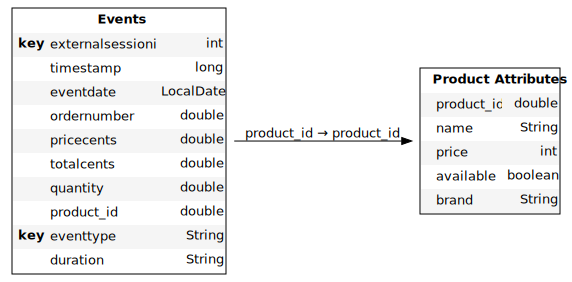

In [15]:
products_ds = session.read_csv("products.csv", store_name="Product Attributes", sep=";")

events_ds.join(products_ds, mapping={"product_id": "product_id"})
cube.schema

In [16]:
# loadig product to category mapping into the cube
products_categories_ds = session.read_csv(
    "product-categories.csv", store_name="Categories"
)
events_ds.join(products_categories_ds, mapping={"product_id": "product_id"})

# loadig categories hierarchy into the cube
categories_tree_ds = session.read_csv(
    "categories_hierarchy.csv",
    store_name="Categories Hierarchy",
    sep=";",
    keys=["Category_Lvl3"],
)
products_categories_ds.join(categories_tree_ds, mapping={"Category": "Category_Lvl3"})

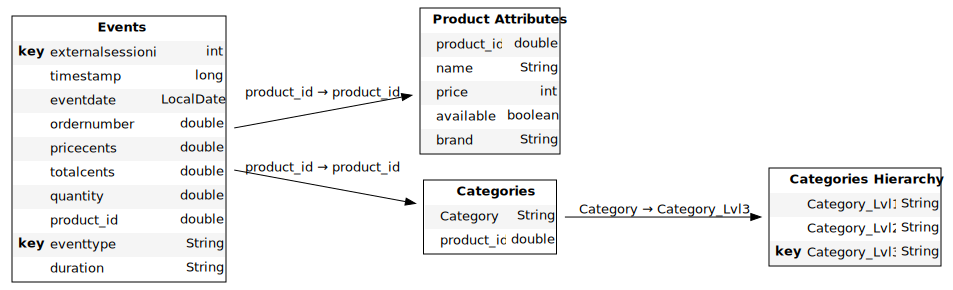

In [18]:
cube.schema

In [19]:
# Creating a multi-level hierarchy to automatically expand data:
cube.hierarchies["Catalog"] = [
    cube.levels["Category_Lvl1"],
    cube.levels["Category_Lvl2"],
    cube.levels["Category"],
]

In [20]:
# A measure to count unique sessions
cube.measures["UniqueSessionsCount"] = tt.agg.count_distinct(
    events_ds["externalsessionid"]
)

In [21]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to see this widget.

In [22]:
cube.measures["Sales"] = cube.measures["totalcents.SUM"]
cube.measures["Sales as % of Grand Total"] = cube.measures["Sales"] / tt.total(
    cube.measures["Sales"], cube.hierarchies["Catalog"]
)
cube.measures["Sales as % of Grand Total"].formatter = "DOUBLE[0.00%]"

In [23]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

# Start building dashboards

In [24]:
session.url

'http://localhost:53222'